In [78]:
import multiprocessing as mp
import subprocess
import sys
import os
import itertools
from scipy.io import savemat
from scipy.io import loadmat
import numpy as np

In [79]:
mp.cpu_count()
num_cycles = 6

In [80]:
set_basis_type = ["Z", "X"];
set_budget_component = ["None", "CZ", "crosstalk", "leakage", "SQ", "DD", "idle", "readout", "Excess"] ;

args = [(basis, budget_component) for basis in set_basis_type  \
                for budget_component in set_budget_component ] ;

In [ ]:
script = "Budget_sim.py"

def run_Budget_sim(basis_type, budget_component):
    subprocess.run([sys.executable, script, str(basis_type), str(budget_component) ])

with mp.Pool(processes = 120) as pool:
    pool.starmap(run_Budget_sim, args)

## Load the data

In [81]:
labels_z = ['Z0', 'Z1', 'Z2', 'Z5', 'Z6', 'Z7', 'Z8']
num_zcheck = len(labels_z) ;

In [82]:
fname0 = './Numerical_data/' + 'Logical_Z_' + 'budget_' + str("None") + '.mat'
data = loadmat(fname0)
syndrome_history_Z_0 = data["syndrome_history_Z"] 
mean_detect_prob_z_0 = np.mean(syndrome_history_Z_0, axis=0)

set_individual_contribution_Z = {};
set_ave_contr_Z = [];
for budget_component in ["CZ", "crosstalk", "leakage", "SQ", "DD", "idle", "readout", "Excess"] :
    
    fname1 = './Numerical_data/' + 'Logical_Z_' + 'budget_' + str(budget_component) + '.mat'
    data1 = loadmat(fname1)

    syndrome_history_Z = data1["syndrome_history_Z"] 
    mean_detect_prob_z = np.mean(syndrome_history_Z, axis=0)
    set_individual_contribution_Z[budget_component] = mean_detect_prob_z_0 - mean_detect_prob_z
    set_ave_contr_Z.append( np.mean( mean_detect_prob_z_0 - mean_detect_prob_z ) )

# for key, item in set_individual_contribution_Z.items():
#     print( np.mean(item) )
set_ave_contr_Z = set_ave_contr_Z/sum(set_ave_contr_Z)

In [83]:
set_ave_contr_Z

array([0.26909829, 0.10279742, 0.01131541, 0.0744088 , 0.09596073,
       0.07458357, 0.18911261, 0.18272316])

In [84]:
# mean_detect_prob_z_0

In [85]:
# [ [ mean_detect_prob_z_0[i + cycle*num_zcheck ] for cycle in range(num_cycles+1) ] for i in range(num_zcheck) ]

In [86]:
# mean_detect_prob_x_0

In [87]:
labels_x = ['X0', 'X1', 'X3', 'X4', 'X5', 'X6', 'X7']
num_xcheck = len(labels_x) ;

In [88]:
fnameX = './Numerical_data/' + 'Logical_X_' + 'budget_' + str("None") + '.mat'
data = loadmat(fnameX)
syndrome_history_X_0 = data["syndrome_history_X"] 
mean_detect_prob_x_0 = np.mean(syndrome_history_X_0, axis=0)

set_individual_contribution_X = {};
set_ave_contr_X = [];
for budget_component in ["CZ", "crosstalk", "leakage", "SQ", "DD", "idle", "readout", "Excess"]  :
    
    fname1 = './Numerical_data/' + 'Logical_X_' + 'budget_' + str(budget_component) + '.mat'
    data1 = loadmat(fname1)
    syndrome_history_X = data1["syndrome_history_X"] 
    mean_detect_prob_x = np.mean(syndrome_history_X, axis=0)
    set_individual_contribution_X[budget_component] = mean_detect_prob_x_0 - mean_detect_prob_x
    set_ave_contr_X.append( np.mean( mean_detect_prob_x_0 - mean_detect_prob_x ) )

# for key, item in set_individual_contribution_X.items():
#     print( np.mean(item) )
set_ave_contr_X = set_ave_contr_X/sum(set_ave_contr_X)

In [89]:
set_ave_contr = (set_ave_contr_X + set_ave_contr_Z)/2

In [95]:
set_ave_contr

array([0.26196556, 0.09810236, 0.007769  , 0.07400696, 0.12598805,
       0.07117088, 0.19113998, 0.1698572 ])

In [91]:
# [ [ mean_detect_prob_x_0[i + cycle*num_xcheck ] for cycle in range(num_cycles+1) ] for i in range(num_xcheck) ]

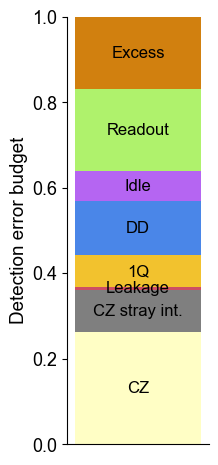

In [96]:
import matplotlib.pyplot as plt
from matplotlib import font_manager 
font_manager.fontManager.addfont('Arial.ttf')
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 13})

segments = [
    ("CZ",               set_ave_contr[0], "#fffec5"),  
    ("CZ stray int.",    set_ave_contr[1], "#7f7f7f"),  
    ("Leakage",          set_ave_contr[2], "#cc4e63"),  # red
    ("1Q",               set_ave_contr[3], "#f2c22e"), 
    ("DD",               set_ave_contr[4], "#4a86e8"), 
    ("Idle",             set_ave_contr[5], "#b565f2"),  
    ("Readout",          set_ave_contr[6], "#aff26c"),  # green
    ("Excess",           set_ave_contr[7], "#d1800f"),    
]
assert abs(sum(h for _, h, _ in segments) - 1.0) < 1e-9, "segments must sum to 1"

fig, ax = plt.subplots(figsize=(2, 4.5))

# 单根柱子的 x 位置与宽度
x = 0
width = 0.8

bottom = 0.0
for label, height, color in segments:
    ax.bar(x, height, width, bottom = bottom, color = color, edgecolor = "none")
    # 居中写字：段比较窄时可以自动调小字号
    y_text = bottom + height/2
    fontsize = 12 if height >= 0.14 else 12
    ax.text(x, y_text, label, ha="center", va="center", color="black", fontsize=fontsize)
    bottom += height

ax.set_xlim(-0.45, 0.45)
ax.set_ylim(0, 1.0)
ax.set_xticks([])

# y 轴刻度 0–1
ax.set_yticks([i/5 for i in range(6)])  # 0,0.2,...,1.0
ax.set_ylabel("Detection error budget", fontsize = 13.5, rotation = 90, labelpad = 3)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# ax.bar(x, 1.0, width, fill=False, edgecolor="black", linewidth=1.5)

plt.subplots_adjust(left = 0.28, bottom = 0.02, top = 0.97, right = 0.99,  hspace = 0.0, wspace = 0.1) 
plt.show()
fig.savefig('Detection error budget.pdf', format='pdf', facecolor='None')